### Import & Install Required Libraires

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import re, os, shutil, requests, random
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tabulate import tabulate

In [ ]:
! pip install bs4 contractions

### Dataset Preparation

##### Load Raw Data
- The dataset is an Amazon Reviews dataset for the "Office Products" category containing customer reviews, ratings, and other relevant information in tab-separated value (TSV) format, compressed as a .gz file
- Below the dataset is downloaded and saved into a local directory

In [35]:
# File URL containing source data
file_url = 'https://web.archive.org/web/20201127142707if_/https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz'

# Local directory location
source_data_dir = 'source_data'
os.makedirs(source_data_dir, exist_ok=True)

# Remove local directory and contents if it exists
if os.path.exists(source_data_dir):
    shutil.rmtree(source_data_dir)
    os.makedirs(source_data_dir, exist_ok=True)

# Download file into local directory
res = requests.get(file_url, stream=True)
res.raise_for_status()
file_name = os.path.join(source_data_dir, os.path.basename(file_url))

with open(file_name, 'wb') as f:
    for chunk in res.iter_content(chunk_size=8192):
        f.write(chunk)

##### Read Data into Pandas Dataframe & Remove Invalid Rating Entries
- Data is read into a Pandas DataFrame, keeping only the review text and star ratings; the rating entries are cleaned by converting them to integers and removing any invalid entries
- Information about the data is printed before and after initial cleaning

In [60]:
# Read data into Pandas dataframe
df = pd.read_csv(
    file_name,
    compression='gzip',
    sep='\t',
    on_bad_lines='skip',
    dtype={7: 'str'},  # Read column 7 (ratings) as string
    low_memory=False
)

In [61]:
# Keep only Reviews and Ratings columns
review_rating = df[['review_body', 'star_rating']]

review_rating.info()
print(f"\nUnique Values in Rating Column:\n{df['star_rating'].unique()}\n")

# Convert string ratings to int
review_rating.loc[:, 'star_rating'] = (
    review_rating['star_rating']
    .apply(lambda x: int(x) if str(x).isdigit() and 1 <= int(x) <= 5 else None)
)

# Drop rows with invalid or missing values in both columns
review_rating = review_rating.dropna(subset=['review_body', 'star_rating'])

# Reset index after dropping rows
review_rating = review_rating.reset_index(drop=True)

review_rating.info()
print(f"\nUnique Values in Rating Column After Cleaning:\n{review_rating['star_rating'].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640254 entries, 0 to 2640253
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_body  object
 1   star_rating  object
dtypes: object(2)
memory usage: 40.3+ MB

Unique Values in Rating Column:
['5' '1' '4' '2' '3' '2015-06-05' '2015-02-11' nan '2014-02-14']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640080 entries, 0 to 2640079
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_body  object
 1   star_rating  object
dtypes: object(2)
memory usage: 40.3+ MB

Unique Values in Rating Column After Cleaning:
[5.0 1.0 4.0 2.0 3.0]


##### Data Exploration & Visualization
- Three reviews with their corresponding ratings are selected and printed
- The counts, percentages, mean, median, and standard deviation of the star ratings are displayed and a bar graph is plotted to provide insights into the rating distribution

Review: These little fuzzy balls have been the favorite of every kitten I've had.  Recently, I rescued a very bright little guy, who is actually smart enough to chase the balls down the stairs and then carry them back up in his mouth to do it again.  The fact that the balls are very soft and comfortable to carry between the teeth makes them very much loved by cats.
Rating: 5.0

Review: This shredder is extremely loud.  Good for about 4-5 papers at a time. You may want to look for something better, or let me know if you want to buy mine:(
Rating: 2.0

Review: Nice laser pointer.  Bought it almost a year ago now and it still shines just as brightly as it did the first day.  My cat loves it!
Rating: 5.0

Value Counts:
star_rating
5.0    1582704
4.0     418348
1.0     306967
3.0     193680
2.0     138381
Name: count, dtype: int64

Percentage Distribution:
star_rating
5.0    59.95
4.0    15.85
1.0    11.63
3.0     7.34
2.0     5.24
Name: count, dtype: float64

Mean Rating: 4.07
Median Ratin

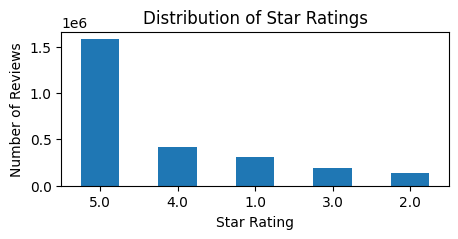

In [62]:
# Print 3 reviews and corresponding ratings
num_rows = len(review_rating.index)
indexes = random.sample(range(0, num_rows), 3)

for i in indexes:
    review, rating = review_rating.loc[i]
    print(f"Review: {review}\nRating: {rating}\n")

# Counts different rating values
value_counts = review_rating['star_rating'].value_counts()
print(f"Value Counts:\n{value_counts}")

# Distribution of rating values
value_counts_percentage = (value_counts / len(review_rating) * 100).round(2)
print(f"\nPercentage Distribution:\n{value_counts_percentage}")

# Mean, median, and std of rating column
mean_rating = review_rating['star_rating'].mean()
median_rating = review_rating['star_rating'].median()
std_rating = review_rating['star_rating'].std()
print(f"\nMean Rating: {mean_rating:.2f}")
print(f"Median Rating: {median_rating:.2f}")
print(f"Standard Deviation of Ratings: {std_rating:.2f}\n")

# Visualize distribution of rating column
value_counts.plot(kind='bar', figsize=(5, 2))
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

##### Create Positive Sentiment Column
- A new column, positive_sentiment, is created to label reviews based on their star ratings: ratings > 3 are labeled as positive (1), ratings < 3 as negative (0), and neutral ratings (3) as 2
- Rows with neutral sentiment (2) are removed

In [63]:
# Create binary labels for data (i.e., ratings > 3 demonstrate positive sentiment (mapped to 1), ratings < 3 demonstrate negative sentiment (mapped to 0), ratings = 3 demonstrate neutral sentiment (mapped to 2)
review_rating['positive_sentiment'] = review_rating['star_rating'].apply(lambda x: 1 if x > 3 else 0 if x < 3 else 2)

print(review_rating['positive_sentiment'].unique())

[1 0 2]


In [64]:
# Counts of sentiment classes (including neutral: 2)
value_counts = review_rating['positive_sentiment'].value_counts()
print(f"Value Counts:\n{value_counts}")

# Drop rows with neutral sentiment
review_rating = review_rating.loc[review_rating['positive_sentiment'] != 2]

# Reset index after dropping rows
review_rating = review_rating.reset_index(drop=True)

print(review_rating['positive_sentiment'].unique())

Value Counts:
positive_sentiment
1    2001052
0     445348
2     193680
Name: count, dtype: int64
[1 0]


##### Condense Dataset
- 100,000 reviews each from the positive and negative sentiment classes are selected to reduce dataset size and balance the classes, ensuring equal representation
- The selected positive and negative reviews are combined into a single DataFrame to be used in the next sections

In [84]:
# Filter positive and negative sentiment reviews to reduce dataset size and balance classes
positive_reviews = review_rating[review_rating['positive_sentiment'] == 1].sample(n=100000)
negative_reviews = review_rating[review_rating['positive_sentiment'] == 0].sample(n=100000)

# Combine samples into one dataset
balanced_df = pd.concat([positive_reviews, negative_reviews]).reset_index(drop=True)
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   review_body         200000 non-null  object
 1   star_rating         200000 non-null  object
 2   positive_sentiment  200000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


### Data Preprocessing

##### Data Cleaning
- Reviews are cleaned by converting text to lowercase, expanding contractions (e.g., "don't" → "do not"), removing HTML tags, URLs, non-alphabetical characters, and extra spaces
- The average review length and a few examples are printed before and after cleaning


In [85]:
from contractions import fix

# Convert to lowercase
balanced_df['cleaned_reviewBody'] = balanced_df['review_body'].str.lower()

# Perform contractions
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].apply(fix)

# Remove HTML and URLs
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].str.replace(r'<br\s*/?>', ' ', regex=True)
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove non-alphabetical characters
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Remove extra spaces
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].str.split().str.join(' ')

In [86]:
# Calculate average lengths
avg_length_before = balanced_df['review_body'].str.len().mean()
avg_length_after = balanced_df['cleaned_reviewBody'].str.len().mean()

print(f"Average length before cleaning: {avg_length_before:.2f} chars")
print(f"Average length after cleaning: {avg_length_after:.2f} chars\n")

# Print few reviews before and after cleaning
num_rows = len(balanced_df.index)
indexes = random.sample(range(0, num_rows), 2)

for i in indexes:
    review_dirty, review_clean = balanced_df['review_body'].loc[i], balanced_df['cleaned_reviewBody'].loc[i]
    print(f"Dirty Review: {review_dirty}\nClean Review: {review_clean}\n")

Average length before cleaning: 316.79 chars
Average length after cleaning: 301.38 chars

Dirty Review: I am happy that I can count on my Canon ink cartridge to be the correct cartridge, brand new, and works great in my Canon printer
Clean Review: i am happy that i can count on my canon ink cartridge to be the correct cartridge brand new and works great in my canon printer

Dirty Review: It does not let you print if the color ink is done..even if there is blank ink..actually there is no choice for printing in black or color..the color ink just depletes even if you use just black..actually i never used color and still color ink is gone..and as I wrote if there is no color ink it just wont print. The printer cartridges are ridiculously pricey..actually you can buy a new printer with the price you pay for those cartridges..
Clean Review: it does not let you print if the color ink is doneeven if there is blank inkactually there is no choice for printing in black or colorthe color ink just 

##### Stop Word Removal & Lemmatization
- Defines a function `preprocess_text` that tokenizes each review, removes stopwords, and lemmatizes (e.g., reducing "builds", "building", or "built" to the lemma "build"remaining words; the processed words are then joined back into a cleaned string
- The preprocess_text function is applied to the cleaned_reviewBody column in the DataFrame, further cleaning and standardizing the reviews
- Again, the average review length and a few examples are printed before and after cleaning

In [87]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Removes stopwords and performs lemmatization
def remove_stopWords_lemmatize(text):
    # Tokenize text into words
    words = text.split()

    # Remove stopwords and lemmatize
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join words back into single string
    return ' '.join(processed_words)

# Apply preprocessing to cleaned_reviewBody column
avg_length_before = balanced_df['cleaned_reviewBody'].str.len().mean()
balanced_df['cleaned_reviewBody'] = balanced_df['cleaned_reviewBody'].apply(remove_stopWords_lemmatize)

# Print avg char length before and after cleaning + stop word removal & lemmatization
avg_length_after = balanced_df['cleaned_reviewBody'].str.len().mean()

print(f"Average length before cleaning: {avg_length_before:.2f} chars")
print(f"Average length after cleaning: {avg_length_after:.2f} chars\n")

# Print sample reviews before and after cleaning + stop word removal & lemmatization
num_rows = len(balanced_df.index)
indexes = random.sample(range(0, num_rows), 3)

for i in indexes:
    review_dirty, review_clean = balanced_df['review_body'].loc[i], balanced_df['cleaned_reviewBody'].loc[i]
    print(f"Dirty Review: {review_dirty}\nClean Review: {review_clean}\n")

Average length before cleaning: 301.38 chars
Average length after cleaning: 186.65 chars

Dirty Review: Has to return the product as the product replaced twice was defective. Purchased directly from monoprice.
Clean Review: return product product replaced twice defective purchased directly monoprice

Dirty Review: I order one of these every year off Amazon.Great price,fast shipping, and it's small not bulky.Just a great planner and if you are looking for a great monthly planner this is the one to buy.
Clean Review: order one every year amazongreat pricefast shipping small bulkyjust great planner looking great monthly planner one buy

Dirty Review: The quality of this deputy ranger star is made of very strong metal.looks great and it draws a lot of attention at work and around the neighborhood .the good thing is that if you wear it in the rain it doesn't rust or change color .I would definite recommend it to friends .
Clean Review: quality deputy ranger star made strong metallooks great

##### Train-Test Split
- Splits the dataset (balanced_df) into 80% training and 20% testing sets while maintaining the class balance (stratified by the positive_sentiment column)
- The size and the class distributions of both sets are printed

In [88]:
# Split the dataset into 80% training and 20% testing
train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['positive_sentiment']
)

value_counts_train = train_df['positive_sentiment'].value_counts()
value_counts_test = test_df['positive_sentiment'].value_counts()

print(f'Training set size: {len(train_df)}')
print(f'Training value counts:\n{value_counts_train}\n')
print(f'Testing set size: {len(test_df)}')
print(f'Testing value counts:\n{value_counts_test}')

Training set size: 160000
Training value counts:
positive_sentiment
0    80000
1    80000
Name: count, dtype: int64

Testing set size: 40000
Testing value counts:
positive_sentiment
1    20000
0    20000
Name: count, dtype: int64


##### Extract TF-ID Features from Sets
- Initializes a TF-IDF vectorizer with a maximum of 5,000 features to convert text data (cleaned_reviewBody) into numerical representations; the vectorizer is fit on the training data and used to transform both training (X_train) and testing (X_test) datasets
- Extracts sentiment labels (positive_sentiment) for training (y_train) and testing (y_test) datasets, and prints the shapes of the resulting TF-IDF feature matrices to confirm dimensionality

In [89]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit on training data and transform
X_train = tfidf.fit_transform(train_df['cleaned_reviewBody'])

# Transform test data
X_test = tfidf.transform(test_df['cleaned_reviewBody'])

# Extract labels
y_train = train_df['positive_sentiment']
y_test = test_df['positive_sentiment']

print(f"TF-IDF Features for Training Data: {X_train.shape}")
print(f"TF-IDF Features for Testing Data: {X_test.shape}")

TF-IDF Features for Training Data: (160000, 5000)
TF-IDF Features for Testing Data: (40000, 5000)


### Modeling

##### Shared Functions
- `evaluate_model` used across all models for calculating, displaying, and saving a variety of classification metrics
- `visualize_results` visualizes the performance across all models

In [108]:
eval_results = []

def evaluate_model(y_true, y_pred, dataset_type, model_type):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    # Print metrics
    print(f"Metrics for {model_type} on {dataset_type} dataset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 50)

    # Save results to eval_results
    eval_results.append({
        'Model': model_type,
        'Dataset': dataset_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

def visualize_results():
    if not eval_results:
        print("No evaluation results to display.")
        return

    # Convert results to DataFrame
    results_df = pd.DataFrame(eval_results)

    # Print results as table
    print("Aggregated Results:")
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

    # Visualize results using bar plots
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        results_df.pivot(index='Model', columns='Dataset', values=metric).plot(
            kind='bar', ax=axs[i], title=metric
        )
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('Model')
        axs[i].legend(title='Dataset', loc='lower right')
        axs[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

##### Perceptron Model
- A Perceptron model is initialized and trained on the TF-IDF-transformed training data (X_train and y_train); predictions are then made on both the training (y_pred_train) and testing (y_pred_test) datasets
- The Perceptron is a simple linear classifier that learns a hyperplane to separate data points into two classes; it predicts a label based on a weighted sum of the input features and a bias
- During training, the model iteratively adjusts the weights using a rule that corrects them when a misclassification occurs; the updates are based on the difference between the predicted and actual labels
- The Perceptron is typically used for binary classification tasks, though it can be extended to multi-class problems using variations like the one-vs-rest strategy

In [109]:
# Initialize Perceptron model
perceptron = Perceptron()

# Train model on training data
perceptron.fit(X_train, y_train)

# Predict on training data
y_pred_train = perceptron.predict(X_train)

# Predict on testing data
y_pred_test = perceptron.predict(X_test)

# Evaluate model on training data
evaluate_model(y_train, y_pred_train, 'Training', 'Perceptron')

# Evaluate model on testing data
evaluate_model(y_test, y_pred_test, 'Testing', 'Perceptron')

Metrics for Perceptron on Training dataset:
Accuracy: 0.8576
Precision: 0.8348
Recall: 0.8916
F1-Score: 0.8623
--------------------------------------------------
Metrics for Perceptron on Testing dataset:
Accuracy: 0.8497
Precision: 0.8267
Recall: 0.8850
F1-Score: 0.8548
--------------------------------------------------


##### SVM Model
- A Perceptron model is initialized and trained on the TF-IDF-transformed training data (X_train and y_train); predictions are then made on both the training (y_pred_train) and testing (y_pred_test) datasets
- SVM finds the optimal hyperplane that separates data points from different classes while maximizing the margin (distance) between the closest points of each class (support vectors); this ensures better generalization to unseen data
- Unlike the Perceptron, which updates weights only on misclassifications, SVM uses a hinge loss function to penalize points near or on the wrong side of the margin, leading to a more robust decision boundary
- SVM focuses on maximizing the margin and can handle noisy data better, while the Perceptron simply adjusts weights based on misclassifications without considering a margin; SVM also supports regularization to prevent overfitting

In [110]:
# Initialize SVM model
svm_model = LinearSVC(max_iter=10)

# Train model on training data
svm_model.fit(X_train, y_train)

# Predict on training data
y_pred_train = svm_model.predict(X_train)

# Predict on testing data
y_pred_test = svm_model.predict(X_test)

# Evaluate model on training data
evaluate_model(y_train, y_pred_train, 'Training', 'SVM')

# Evaluate model on testing data
evaluate_model(y_test, y_pred_test, 'Testing', 'SVM')

Metrics for SVM on Training dataset:
Accuracy: 0.9044
Precision: 0.9073
Recall: 0.9008
F1-Score: 0.9040
--------------------------------------------------
Metrics for SVM on Testing dataset:
Accuracy: 0.8929
Precision: 0.8931
Recall: 0.8927
F1-Score: 0.8929
--------------------------------------------------


##### Logistic Regression Model
- A Logistic Regression model is initialized and trained on the TF-IDF-transformed training data (X_train and y_train); predictions are then made on both the training (y_pred_train) and testing (y_pred_test) datasets
- Logistic Regression predicts probabilities for each class using a logistic (sigmoid) function, converting the weighted sum of input features into a value between 0 and 1. A threshold (e.g., 0.5) is used to classify data points
- It minimizes the log-loss (cross-entropy loss), which penalizes wrong predictions based on how confident they are, making it a probabilistic model rather than a hard-margin classifier like SVM
- Unlike SVM and Perceptron, Logistic Regression produces probabilistic outputs and directly models the likelihood of class membership; it doesn’t focus on maximizing a margin but instead aims to fit the data by minimizing classification error through log-loss; this makes it more interpretable and better for problems where probabilities are needed

In [111]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train model on training data
logistic_model.fit(X_train, y_train)

# Predict on training data
y_pred_train = logistic_model.predict(X_train)

# Predict on testing data
y_pred_test = logistic_model.predict(X_test)

# Evaluate model on training data
evaluate_model(y_train, y_pred_train, 'Training', 'Logistic Regression')

# Evaluate model on testing data
evaluate_model(y_test, y_pred_test, 'Testing', 'Logistic Regression')

Metrics for Logistic Regression on Training dataset:
Accuracy: 0.9000
Precision: 0.9044
Recall: 0.8946
F1-Score: 0.8994
--------------------------------------------------
Metrics for Logistic Regression on Testing dataset:
Accuracy: 0.8953
Precision: 0.8969
Recall: 0.8932
F1-Score: 0.8951
--------------------------------------------------


##### Multinomial Naive Bayes Model
- A Multinomial Naive Bayes model is initialized and trained on the TF-IDF-transformed training data (X_train and y_train); predictions are then made on both the training (y_pred_train) and testing (y_pred_test) datasets
- Multinomial Naive Bayes is based on Bayes' Theorem and assumes that features (e.g., word counts or TF-IDF scores) are conditionally independent given the class label; it calculates the probability of each class and assigns the one with the highest probability to the input
- This model is particularly effective for text classification tasks, as it assumes feature values (like word frequencies) follow a multinomial distribution; it uses pre-computed probabilities from training data to classify new data points quickly
- Unlike SVM, Logistic Regression, and Perceptron, which are more general-purpose classifiers using hyperplanes and optimization techniques, Multinomial Naive Bayes relies on strong independence assumptions and is computationally lightweight; it's typically faster but can struggle when the independence assumption doesn't hold

In [112]:
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train model on training data
nb_model.fit(X_train, y_train)

# Predict on training data
y_pred_train = nb_model.predict(X_train)

# Predict on testing data
y_pred_test = nb_model.predict(X_test)

# Evaluate model on training data
evaluate_model(y_train, y_pred_train, 'Training', 'Multinomial Naive Bayes')

# Evaluate model on testing data
evaluate_model(y_test, y_pred_test, 'Testing', 'Multinomial Naive Bayes')

Metrics for Multinomial Naive Bayes on Training dataset:
Accuracy: 0.8627
Precision: 0.8629
Recall: 0.8625
F1-Score: 0.8627
--------------------------------------------------
Metrics for Multinomial Naive Bayes on Testing dataset:
Accuracy: 0.8588
Precision: 0.8576
Recall: 0.8605
F1-Score: 0.8591
--------------------------------------------------


##### Compare Model Performances

Aggregated Results:
+----+-------------------------+-----------+------------+-------------+----------+------------+
|    | Model                   | Dataset   |   Accuracy |   Precision |   Recall |   F1-Score |
+====+=========================+===========+============+=============+==========+============+
|  0 | Perceptron              | Training  |   0.857569 |    0.834806 | 0.891563 |   0.862251 |
+----+-------------------------+-----------+------------+-------------+----------+------------+
|  1 | Perceptron              | Testing   |   0.849725 |    0.826678 | 0.885    |   0.854845 |
+----+-------------------------+-----------+------------+-------------+----------+------------+
|  2 | SVM                     | Training  |   0.904356 |    0.907263 | 0.900787 |   0.904014 |
+----+-------------------------+-----------+------------+-------------+----------+------------+
|  3 | SVM                     | Testing   |   0.892925 |    0.893102 | 0.8927   |   0.892901 |
+----+--------------

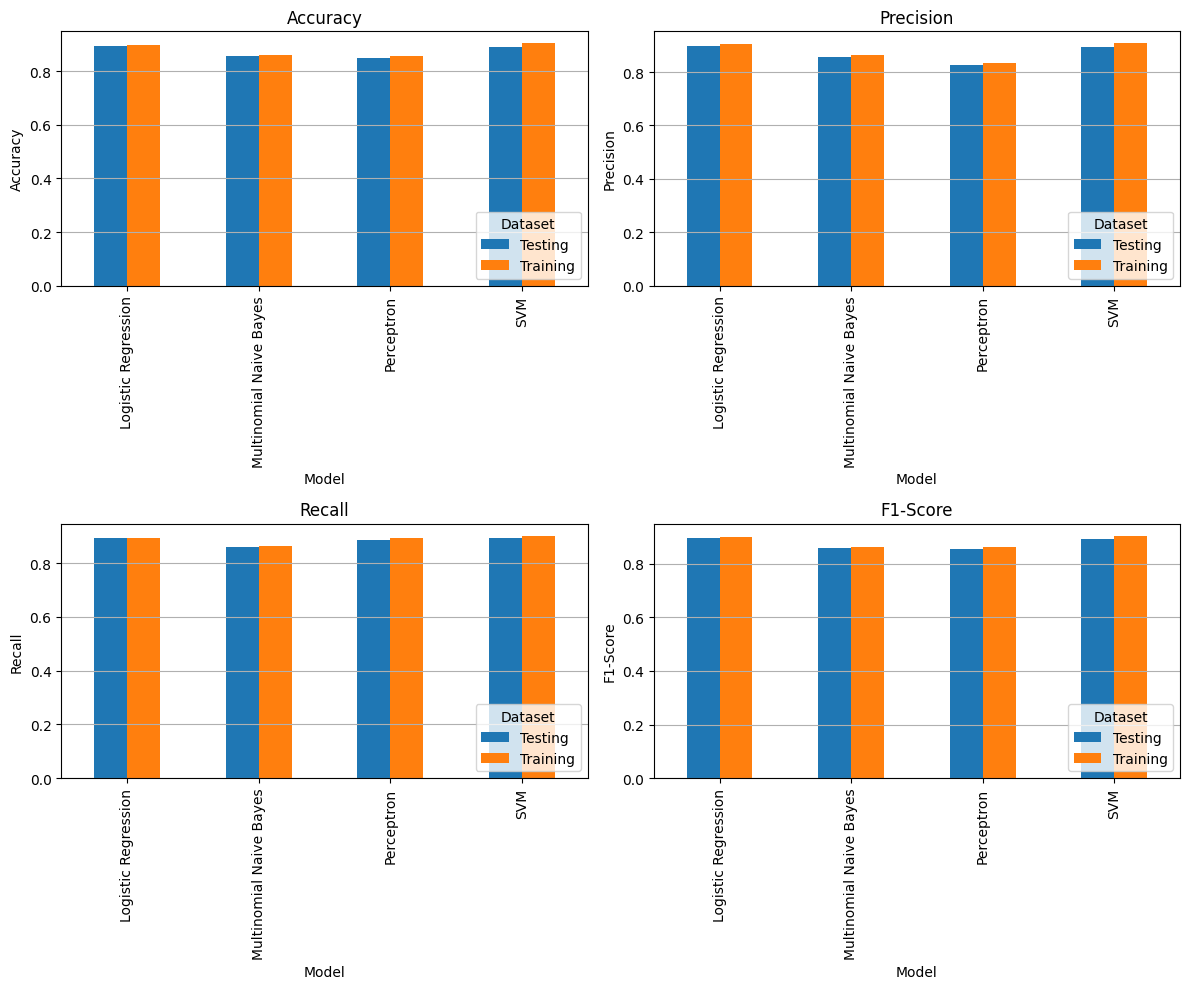

In [113]:
visualize_results()